In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


metrics = ['f1_cd','f1_ln']
mappings = ['incremental','procrustes','twec']
embeddings = ['pretrained','none']
results_path = './output/**/**/results'


results_df = pd.DataFrame()
path = '../output/**/**/results'
text_files = set(glob.glob(path + "/**/*.pkl", recursive=True))
for file in text_files:
    results_df = pd.concat([results_df, pd.read_pickle(file)], ignore_index=True, axis=0)

results_df.to_csv('../language_drift_results', index=False)

results_df = pd.read_csv('../language_drift_results')
print(results_df.head())

## Research Questions
### 1. Which vectors' alignment method performs better?

### Null Hypothesis: 
Αll mapping methods we investigate(‘procrustes’, ‘incremental’, ‘twec’) perform equally across different executions on the same datasets and parameters.


In [ ]:
# deep copy
mapping_df = results_df.copy(deep=True)
# remove "lda2vec" and "pretrained" executions
#mapping_df = mapping_df.loc[(mapping_df['pretrained'] == 'None') & (mapping_df['w2vec_algorithm'] != 'lda2vec')]



mapping_df = mapping_df.drop(mapping_df[((mapping_df['pretrained'] == 'None') 
                                         & (mapping_df['w2vec_algorithm'] != 'lda2vec'))])
                                         
                                         
# remove unnecassery columns
mapping_df = mapping_df.drop(['precision_cd','precision_ln','accuracy_cd','accuracy_ln',
          'recall_cd','recall_ln','data_set_id','dim','window_size','pretrained','t'],axis=1)

mapping_df = mapping_df.melt(id_vars=["language", "w2vec_algorithm","mapping"], 
        var_name="metric", 
        value_name="f1_score")

# remove Nan values from f1_scores
mapping_df = mapping_df[mapping_df['f1_score'].notna()]

# remove unnecassery columns
mapping_df = mapping_df.drop('metric',axis=1)

# create pivot table
#pivot_mappings = mapping_df.pivot_table(index=['language','w2vec_algorithm'], columns="mapping", values=['f1_score']).reset_index()
#pivot_cd['mean_f1'] = pivot_cd.loc[:, (['f1_cd','f1_ln'], slice(None))].mean(axis=1)
print(mapping_df.head())
print(mapping_df.head())

### 1. Shapiro-Wilk Test (checks normality of distribution)

In [ ]:
# Shapiro-Wilk test
from collections import defaultdict
from scipy import stats

alpha =0.05

print("Shapiro-Wilk test for normal distribution: \n")
mapping_normality_dict = defaultdict()
for mapping in mappings:
    stat, p = stats.shapiro( mapping_df.loc[mapping_df['mapping'] == str(mapping),'f1_score'])
    print(mapping)
    if p >= alpha:
        print("\t has a normal distribution with pvalue = "+ str(p) + ", stat=",str(stat))
        mapping_normality_dict[mapping] = True
    else:
        print("\t has NOT a normal distribution with pvalue = ", p, "stat=",stat)
        mapping_normality_dict[mapping] = False

### Normality Results
**Incremental** and **twec** method can be described by the normal distribution.

However since **procrustes** method does not meet the criteria of the normality <u>we have to go through with non parapetric tests.</u>

### 1.2 Friedman test (non parametric - normality is not a prerequisite)
* Prerequisites (non normal distributions, paired samples, more than two groups)
* Samples are paired since all variables except the under investigation variable are shared among the different populations
* H0: Populations have same distributions


In [ ]:
# Friedman test (non parametric - normality is not a prerequisite)
# Compare groups of incremental, procrustes and twec

alpha =0.05

print("Friedman H-test: \n\n incremental-procrustes")
stat, p = stats.friedmanchisquare(
    mapping_df.loc[mapping_df['mapping'] == 'incremental','f1_score'],
    mapping_df.loc[mapping_df['mapping'] == 'procrustes','f1_score'],
    mapping_df.loc[mapping_df['mapping'] == 'twec','f1_score'])

if p >= alpha:
    print("    Same distributions (fail to reject H0) with pvalue = ",p, "stat=",stat)
else:
    print("    Different distributions (reject H0) = ", p, "stat=",stat)


In [ ]:
### Wilcoxon Signed-Rank Test (non parametric - normality is not a prerequisite)
* Prerequisites (non normal distributions, paired samples, two populations)
* Samples are paired since all variables except the under investigation variable are shared among the different populations
* H0: Populations have same distributions


In [ ]:
# Wilcoxon Signed-Rank Test (non parametric - normality is not a prerequisite)
# Compare groups of incremental, procrustes and twec

# Kruskal-Wallis H-test (non parametric - normality is not a prerequisite)
# Compare groups of rbf-svm, linear, sigmoid, poly.

alpha =0.05

print("Wilcoxon Signed-Rank H-test: \n\n incremental-procrustes")
stat, p = stats.wilcoxon(
    mapping_df.loc[mapping_df['mapping'] == 'incremental','f1_score'],
    mapping_df.loc[mapping_df['mapping'] == 'procrustes','f1_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)
    
print("\n incremental-twec")
stat, p = stats.wilcoxon(
    mapping_df.loc[mapping_df['mapping'] == 'incremental','f1_score'],
    mapping_df.loc[mapping_df['mapping'] == 'twec','f1_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)

print("\n procrustes-twec")
stat, p = stats.wilcoxon(
    mapping_df.loc[mapping_df['mapping'] == 'procrustes','f1_score'],
    mapping_df.loc[mapping_df['mapping'] == 'twec','f1_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)

In [ ]:
### Kruskal-Wallis Test is not the proper statistical test!!!
### Samples are paired since all variables except the under investigation variable are shared among the different populations

In [ ]:
# Kruskal-Wallis H-test (non parametric - normality is not a prerequisite)
# Compare groups of rbf-svm, linear, sigmoid, poly.

alpha =0.05

print("Kruskal-Wallis H-test: \n\n incremental-procrustes")
stat, p = stats.kruskal(
    mapping_df.loc[mapping_df['mapping'] == 'incremental','f1_score'],
    mapping_df.loc[mapping_df['mapping'] == 'procrustes','f1_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)
    
print("\n incremental-twec")
stat, p = stats.kruskal(
    mapping_df.loc[mapping_df['mapping'] == 'incremental','f1_score'],
    mapping_df.loc[mapping_df['mapping'] == 'twec','f1_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)

print("\n procrustes-twec")
stat, p = stats.kruskal(
    mapping_df.loc[mapping_df['mapping'] == 'procrustes','f1_score'],
    mapping_df.loc[mapping_df['mapping'] == 'twec','f1_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)

### Results
In the implemented **Word2Vec** parameter setting:
- **embeddings_dimension = 100**
- **window_size = 10**
- **min_count = 3** (number of occurences)
- **s = 0.001** (threshold for configuring which higher-frequency words are randomly downsampled)
- **k = 5** number of negative samples parameter 
- **epochs = 5**

After the execution on the following combinations:
- **cbow-sgns** (algorithm)
- **incremental-procrustes-twec** (alignment)
- **en-de-swe-lat** (languages)
- **cd-ln** (metrics of cosine distance and local_neighborhood measure)

We had the chance to investigated the result of 80 executions ()

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot( saturation=1, palette='BuGn',ax=ax, whis=[5, 95],x=mapping_df['mapping'],y=mapping_df['f1_score'])
# specify axis labels
plt.xlabel('', size=14, family='monospace')
plt.ylabel('', size=14, family='monospace')
plt.title('F1 Scores per Alignment Method')
plt.show()

In [ ]:
"""

final_mappings = pivot_mappings

count=1
# create dataframe containing mean f1 scores of each mapping across different metrics
for mapping in mappings:
    result = 0
    for metric in metrics:
        result += pivot_mappings[metric][mapping]
        final_mappings = final_mappings.drop((metric, mapping), axis = 1)
    result =result/(len(metrics))
    
    final_mappings = pd.concat([final_mappings, result], axis=1)

#del pivot_cd
# fix dataframe naming
final_mappings.rename(columns = {('language', ''):'language',('w2vec_algorithm', ''):'w2vec'}, inplace = True)
print(final_mappings)

for i in range(1):
    print(type(pivot_cd.xs('procrustes', axis=1, level=1, drop_level=False).mean(axis=1)))
    print(pivot_cd.xs('procrustes', axis=1, level=1, drop_level=False))
    print(pivot_cd.xs('f1_cd', axis=1, level=0, drop_level=False))
pivot_ln = df.pivot_table(index=['language','w2vec_algorithm'], columns="mapping", values=['f1_ln'])
print(pivot_ln)
"""

## Research Questions
#### 2. Do pretrained embeddings improve performance? in cases of procrustes and incremental alignment methods?
#### Null Hypothesis: 
Executions with pretrained embeddings perform equally with those that haven't been prior initialized.

In [ ]:
# deep copy
pretrained_df = results_df.copy(deep=True)
# remove "lda2vec" 
pretrained_df = pretrained_df.loc[(pretrained_df['w2vec_algorithm'] != 'lda2vec')]

# remove unnecassery columns
pretrained_df = pretrained_df.drop(['precision_cd','precision_ln','accuracy_cd','accuracy_ln',
          'recall_cd','recall_ln','data_set_id','dim','window_size','t','mapping'],axis=1)

# transform 'f1_cd', 'f1_ln' columns to 'f1_score' column
pretrained_df = pretrained_df.melt(id_vars=["language", "w2vec_algorithm","pretrained"], 
        var_name="metric", 
        value_name="f1_score")

# remove Nan values from f1_scores
pretrained_df = pretrained_df[pretrained_df['f1_score'].notna()]

# remove unnecassery columns
pretrained_df = pretrained_df.drop('metric',axis=1)

pretrained_df['pretrained'] = np.where(pretrained_df['pretrained'] == "None", 'none', 'pretrained')
print(pretrained_df.head())

### Shapiro-Wilk Test

In [ ]:
# Shapiro-Wilk test
from scipy import stats
alpha =0.5

print("Test f1 scores normality for: \n")
for embedding in embeddings:
    stat, p = stats.shapiro( pretrained_df.loc[pretrained_df['pretrained'] == str(embedding),'f1_score'])
    print(embedding," embeddings")
    if p < alpha:
        print("    Hypothesis of normality REJECTED with pvalue = ", p, "stat=",stat)
    else:
        print("    Hypothesis of normality was ACCEPTED with pvalue = ",p, "stat=",stat)

In [ ]:
### Kruskal-Wallis Test

In [ ]:
# Kruskal-Wallis H-test (non parametric - normality is not a prerequisite)
# Compare groups of rbf-svm, linear, sigmoid, poly.

alpha =0.08

print("Kruskal-Wallis H-test: \n\n pretrained - none ")
stat, p = stats.kruskal(
    pretrained_df.loc[pretrained_df['pretrained'] == 'none','f1_score'],
    pretrained_df.loc[pretrained_df['pretrained'] == 'pretrained','f1_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)
    

### Results
The usage of pretrained embeddings improves F1 scores. 

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot( saturation=1, palette='BuGn',ax=ax, whis=[5, 95],x=pretrained_df['pretrained'],y=pretrained_df['f1_score'])
# specify axis labels
plt.xlabel('', size=14, family='monospace')
plt.ylabel('', size=14, family='monospace')
plt.title('F1 Scores per Pretrained Embeddings Method')
plt.show()

In [ ]:
# Kruskal-Wallis H-test (non parametric - normality is not a prerequisite)
# Compare groups of rbf-svm, linear, sigmoid, poly.

alpha =0.08

print("Kruskal-Wallis H-test: \n\n pretrained - none ")
stat, p = stats.kruskal(
    pretrained_df.loc[pretrained_df['pretrained'] == 'none','f1_score'],
    pretrained_df.loc[pretrained_df['pretrained'] == 'pretrained','f1_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)
    

### Results
The usage of pretrained embeddings improves F1 scores. 

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot( saturation=1, palette='BuGn',ax=ax, whis=[5, 95],x=pretrained_df['pretrained'],y=pretrained_df['f1_score'])
# specify axis labels
plt.xlabel('', size=14, family='monospace')
plt.ylabel('', size=14, family='monospace')
plt.title('F1 Scores per Pretrained Embeddings Method')
plt.show()

In [17]:
# Kruskal-Wallis H-test (non parametric - normality is not a prerequisite)
# Compare groups of rbf-svm, linear, sigmoid, poly.

alpha =0.08

print("Kruskal-Wallis H-test: \n\n pretrained - none ")
stat, p = stats.kruskal(
    pretrained_df.loc[pretrained_df['pretrained'] == 'none','f1_score'],
    pretrained_df.loc[pretrained_df['pretrained'] == 'pretrained','f1_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)
    

Kruskal-Wallis H-test: 

 pretrained - none 
    Null Hypothesis REJECTED with pvalue =  0.0059728160542482445 stat= 7.558485638878811


### Results
The usage of pretrained embeddings improves F1 scores. 

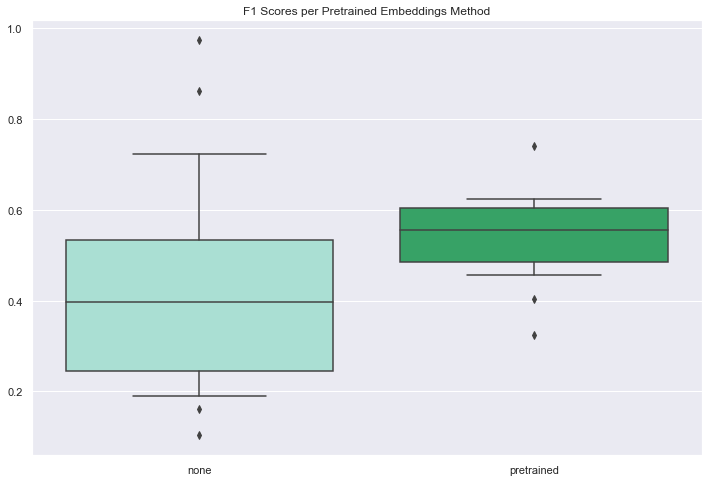

In [18]:
sns.set()
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot( saturation=1, palette='BuGn',ax=ax, whis=[5, 95],x=pretrained_df['pretrained'],y=pretrained_df['f1_score'])
# specify axis labels
plt.xlabel('', size=14, family='monospace')
plt.ylabel('', size=14, family='monospace')
plt.title('F1 Scores per Pretrained Embeddings Method')
plt.show()

In [19]:
# Kruskal-Wallis H-test (non parametric - normality is not a prerequisite)
# Compare groups of rbf-svm, linear, sigmoid, poly.

alpha =0.08

print("Kruskal-Wallis H-test: \n\n pretrained - none ")
stat, p = stats.kruskal(
    pretrained_df.loc[pretrained_df['pretrained'] == 'none','f1_score'],
    pretrained_df.loc[pretrained_df['pretrained'] == 'pretrained','f1_score'])

if p < alpha:
    print("    Null Hypothesis REJECTED with pvalue = ", p, "stat=",stat)
else:
    print("    Null hypothesis was ACCEPTED with pvalue = ",p, "stat=",stat)
    

Kruskal-Wallis H-test: 

 pretrained - none 
    Null Hypothesis REJECTED with pvalue =  0.0059728160542482445 stat= 7.558485638878811


### Results
The usage of pretrained embeddings improves F1 scores. 

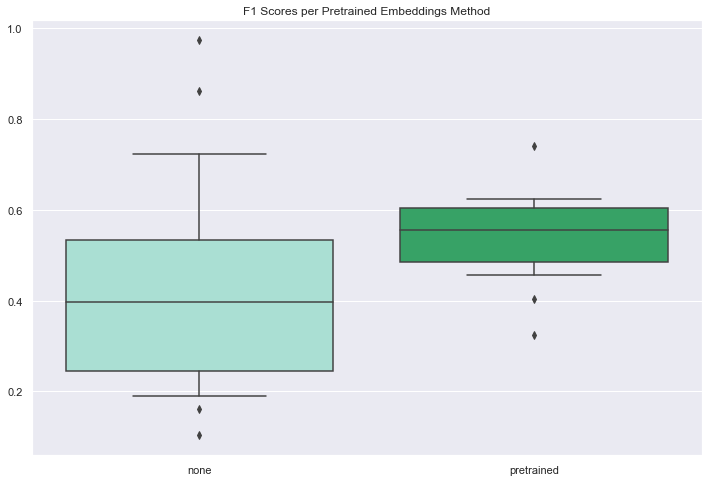

In [20]:
sns.set()
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot( saturation=1, palette='BuGn',ax=ax, whis=[5, 95],x=pretrained_df['pretrained'],y=pretrained_df['f1_score'])
# specify axis labels
plt.xlabel('', size=14, family='monospace')
plt.ylabel('', size=14, family='monospace')
plt.title('F1 Scores per Pretrained Embeddings Method')
plt.show()

In [ ]:
## Research Questions
#### 2. Do pretrained embeddings improve performance? in cases of procrustes and incremental alignment methods?
#### Null Hypothesis: 
Executions with pretrained embeddings perform equally with those that haven't been prior initialized.

## Research Questions
#### 2. Do pretrained embeddings improve performance? in cases of procrustes and incremental alignment methods?
#### Null Hypothesis: 
Executions with pretrained embeddings perform equally with those that haven't been prior initialized.

In [ ]:
final_mappings = pivot_mappings

count=1
# create dataframe containing mean f1 scores of each mapping across different metrics
for mapping in mappings:
    result = 0
    for metric in metrics:
        result += pivot_mappings[metric][mapping]
        final_mappings = final_mappings.drop((metric, mapping), axis = 1)
    result =result/(len(metrics))
    
    final_mappings = pd.concat([final_mappings, result], axis=1)

#del pivot_cd
# fix dataframe naming
final_mappings.rename(columns = {('language', ''):'language',('w2vec_algorithm', ''):'w2vec','incremental':'mean_incremental',
                        'procrustes':'mean_procrustes','twec':'mean_twec'}, inplace = True)
print(final_mappings)


### Shapiro-Wilk Test

### Kruskal-Wallis Test

In [ ]:
"""
for i in range(1):
    print(type(pivot_cd.xs('procrustes', axis=1, level=1, drop_level=False).mean(axis=1)))
    print(pivot_cd.xs('procrustes', axis=1, level=1, drop_level=False))
    print(pivot_cd.xs('f1_cd', axis=1, level=0, drop_level=False))
pivot_ln = df.pivot_table(index=['language','w2vec_algorithm'], columns="mapping", values=['f1_ln'])
print(pivot_ln)
"""

## Research Questions
#### 2. Do pretrained embeddings improve performance? in cases of procrustes and incremental alignment methods?
#### Null Hypothesis: 
Executions with pretrained embeddings perform equally with those that haven't been prior initialized.